# IMPORTAÇÃO DOS PACOTES

In [1]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions
from lifetimes.datasets import load_dataset
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error, confusion_matrix, mean_absolute_error, f1_score, r2_score
from math import sqrt
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# IMPORTAÇÃO DO DATASET E PREPARAÇÃO DOS DADOS

In [2]:
df = load_dataset(filename='CDNOW_sample.txt', 
    #header=None, 
    delim_whitespace=True, 
    names=['id_cliente', 'index_cliente', 'data', 'quantidade', 'preco'],
    converters={'data': lambda x: pd.to_datetime(x, format="%Y-%m-%d")}
)

df.head(3)

,id_cliente,index_cliente,data,quantidade,preco
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96


In [3]:
#Criando um parâmetro de Valor Total
df["valor"] = df["preco"]*df["quantidade"]

In [4]:
#df.groupby(['id_cliente','data_transacao']).agg({'valor':'sum'}).reset_index().sort_values(by='id_cliente')
df = df[['id_cliente','data','valor']]

In [5]:
#Estatística descritiva
df.describe()

,id_cliente,valor
count,6919.000000,6919.000000
mean,11682.515826,152.643537
std,6833.386793,541.151076
min,4.000000,0.000000
25%,5525.000000,14.735000
50%,11749.000000,49.490000
75%,17717.000000,123.930000
max,23569.000000,20278.800000


In [6]:
#Nenhum valor nulo
df.isnull().sum()

id_cliente    0
data          0
valor         0
dtype: int64

# Matriz de RFM

In [7]:
rfm = summary_data_from_transaction_data(df,'id_cliente','data','valor')#,include_first_transaction=True)
rfm = rfm[~rfm.isna()] #Caso haja algum valor nulo, seriam removidos.
rfm.head()

,frequency,recency,T,monetary_value
id_cliente,,,,
4,3.0,345.0,545.0,42.46
18,0.0,0.0,542.0,0.00
21,1.0,12.0,545.0,11.77
50,0.0,0.0,545.0,0.00
60,0.0,0.0,514.0,0.00


# Predição da quantidade de transações e probabilidade de o cliente virar um churn

In [ ]:
#Remoção de frequências e valores monetários zerados
rfm = rfm[(rfm['frequency'] > 0) & (rfm['monetary_value'] > 0)]

In [8]:
#Criação e treinamento do modelo.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.61, alpha: 38.13, b: 2.65, r: 0.25>

In [9]:
#Previsão da quantidade de compras dos próximos 90 dias.
t = 90 #Previsão dos próximos 90 dias
rfm['predicao_'+str(t)+'_dias'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,rfm['frequency'], rfm['recency'],rfm['T'])

In [10]:
#Criação das colunas Retenção e Churn
rfm['Retention'] = bgf.conditional_probability_alive(rfm['frequency'], rfm['recency'], rfm['T'])
rfm['Churn'] = 1-bgf.conditional_probability_alive(rfm['frequency'], rfm['recency'], rfm['T'])

# Hipóteses do modelo Gamma Gamma

In [11]:
#Analise da correlação entre os campos de frequência e valor monetário, que precisa ser baixa
rfm[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.028509
monetary_value,0.028509,1.000000


# Predição do CLV

In [12]:
#Criação e treinamento do modelo GAMMA GAMMA.
ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(rfm['frequency'], rfm['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1139 subjects, p: 2.16, q: 1.22, v: 25.64>

In [13]:
preds_total = ggf.customer_lifetime_value(
    bgf,
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time = 3, #previsão do CLV dos últimos 3 meses.
    freq='D',
    discount_rate = 0.01 #desconto do fluxo de caixa da empresa
)
rfm['clv'] = preds_total

In [14]:
rfm['segmentacao_clv'] = pd.qcut(rfm['clv'], q=5, labels=['Baixíssimo', 'Baixo', 'Médio', 'Alto', 'Top']) #Segmentação dos clientes em 5 
#grupos de igual quantidade de valores  
rfm.head()

,frequency,recency,T,monetary_value,predicao_90_dias,Retention,Churn,clv,segmentacao_clv
id_cliente,,,,,,,,,
4,3.0,345.0,545.0,42.460000,0.321990,0.661119,0.338881,15.584225,Médio
21,1.0,12.0,545.0,11.770000,0.031631,0.167448,0.832552,1.054904,Baixíssimo
111,15.0,535.0,545.0,189.383333,2.160054,0.954654,0.045346,402.044193,Top
112,1.0,35.0,545.0,11.770000,0.046106,0.244077,0.755923,1.537653,Baixíssimo
113,2.0,430.0,545.0,13.380000,0.265669,0.785425,0.214575,6.500225,Baixo


# VALIDAÇÃO DO MODELO

In [15]:
# Primeiramente, definimos a predição do modelo.
# O número real de transações no período observado, precisa ser acrescentado de 1.
valores_reais  = rfm["frequency"] #+ 1

# Tempo do dataset
tempo = (df.data.max()-df.data.min()).days

# Predizer o número de transações do tempo observado do dataset.
valores_preditos = bgf.predict(t=tempo, frequency=rfm['frequency'], recency=rfm['recency'], T=rfm['T'])

valores_reais = valores_reais.fillna(0)
valores_preditos = valores_preditos.fillna(0)

RMSE = mean_squared_error(y_true = valores_reais, y_pred = valores_preditos, squared = False)

RMSE

2.631772346200048

Mean absolute error: 1.5997010769132896


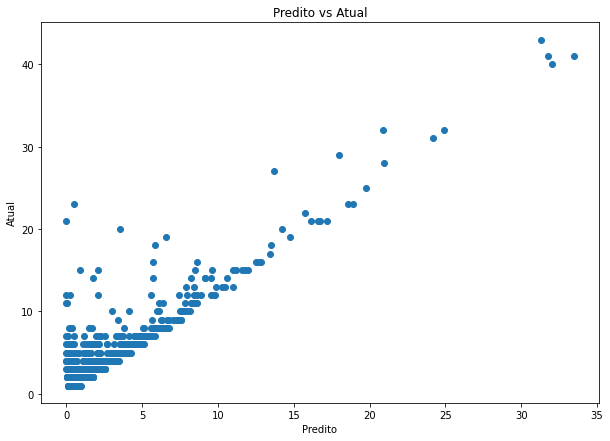

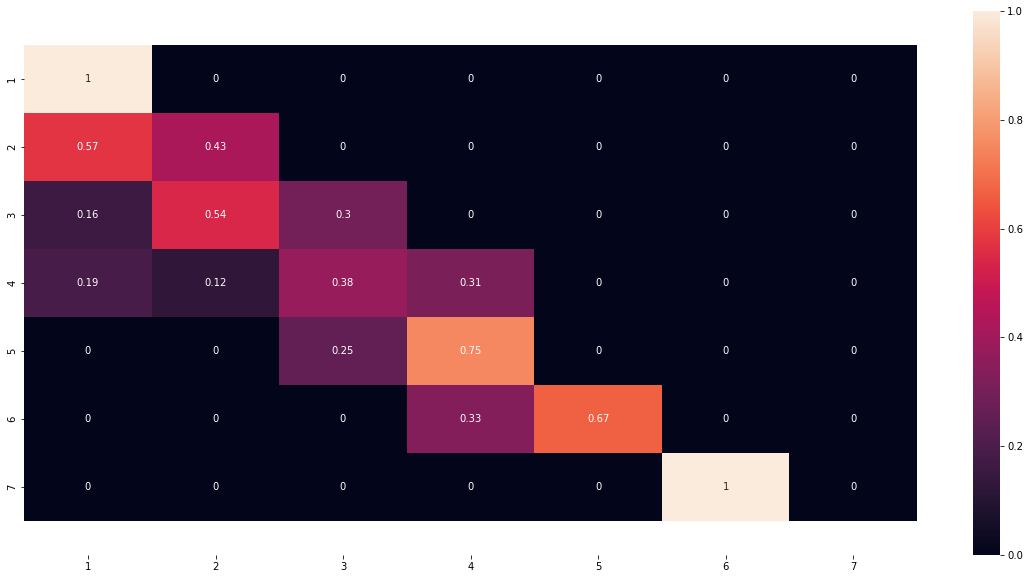

F1 score: 0.3258443374477299
Amostra em cada bin: 

0.0    856
1.0    195
2.0     61
3.0     16
4.0      4
6.0      4
5.0      3
dtype: int64


In [16]:
def validar_clv(atual, predito, bins):
    print(f"Mean absolute error: {mean_absolute_error(atual, predito)}")
    #Evaluate numeric
    plt.figure(figsize=(10, 7))
    plt.scatter(predito, atual)
    plt.xlabel('Predito')
    plt.ylabel('Atual')
    plt.title('Predito vs Atual')
    plt.show()
    
    #Avaliar os Bins
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    est.fit(np.array(atual).reshape(-1, 1))
    bin_atual = est.transform(np.array(atual).reshape(-1, 1)).ravel()
    bin_predito = est.transform(np.array(predito).reshape(-1, 1)).ravel()
    
    cm = confusion_matrix(bin_atual, bin_predito, normalize='true')
    df_cm = pd.DataFrame(cm, index = range(1, bins+1),
                      columns = range(1, bins+1))
    plt.figure(figsize = (20,10))
    sns.heatmap(df_cm, annot=True)

    # Visualização
    b, t = plt.ylim() # descobrir os valores para a base e o topo
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    print(f'F1 score: {f1_score(bin_atual, bin_predito, average="macro")}')
    print('Amostra em cada bin: \n')
    print(pd.Series(bin_atual).sort_values().value_counts())

validar_clv(valores_reais, valores_preditos, bins=7)

<AxesSubplot:title={'center':'Frequência de Transações Repetidas'}, xlabel='Número de transações do período de calibração', ylabel='Clientes'>

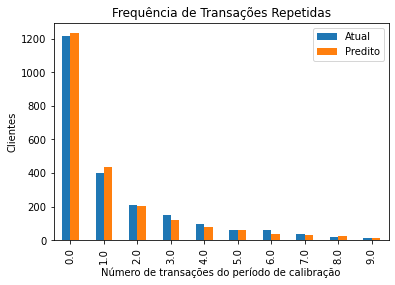

In [17]:
plot_period_transactions(bgf, max_frequency=10, title='Frequência de Transações Repetidas',
    xlabel='Número de transações do período de calibração',
    ylabel='Clientes', label=(["Atual","Predito"]))
#Aqui mostra a comparação entre as frequencias reais e preditas dos dados. Parece está acurado.

# Comparação entre o valor médio do conjunto de dados e o do modelo

In [27]:
#Também, posso fazer a previsão do valor médio do modelo para compará-lo com o valor médio real do conjunto de dados, visto que 
#a multiplicação deste parâmetro com a predição da quantidade de compras que serão feitas formam o clv. Assim, posso mensurar 
#melhor a performance do modelo.
predicao_valor_monetario = ggf.conditional_expected_average_profit(
        rfm['frequency'],
        rfm['monetary_value']
)

<AxesSubplot:xlabel='monetary_value', ylabel='Density'>

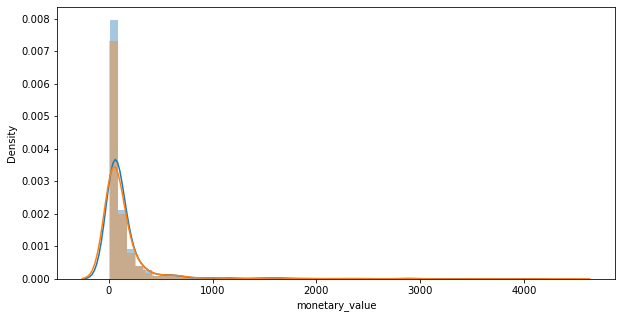

In [29]:
#Quanto mais próximos estiverem os valores, melhor será a previsão do modelo.
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(predicao_valor_monetario,ax=ax)
sns.distplot(rfm['monetary_value'],ax=ax)